In [1]:
import torch
from torch import nn, optim
from torch.autograd.variable import Variable
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from utils import Logger
from matplotlib import cm
from toySphere import sphere
import numpy as np
import random

In [2]:
torch.set_default_tensor_type('torch.DoubleTensor')

# Custom dataloader for 3D spheres dataset, Justin's version with create_noise and add dims  
class ToySpheres(Dataset):

    def __init__(self, shape, seed, transform=None):
        random.seed(seed)
        self.data_dir = []
        self.dataShape = shape
        print('Creating training data...')
        for _ in range(shape[0]):
            s_x = random.randint(-shape[2]//2 + 2, shape[2]//2 - 2)
            s_y = random.randint(-shape[3]//2 + 2, shape[3]//2 - 2)
            s_z = random.randint(-shape[4]//2 + 2, shape[4]//2 - 2)
            s_r = random.uniform(1.1, 8.0)
            self.data_dir.append((s_x, s_y, s_z, s_r))
        print('Complete!')
        self.transform = transform

    def __len__(self):
        return len(self.data_dir)

    def __getitem__(self, idx):
        params = self.data_dir[idx]
        model = np.expand_dims(sphere(self.dataShape[2], self.dataShape[3], self.dataShape[4],
                                      params[0],
                                      params[1],
                                      params[2],
                                      params[3]), axis=0)
        if self.transform:
            model = self.transform(model)
        return torch.from_numpy(model)
    
# Load data
dataset = ToySpheres((6000, 1, 16, 16, 16), 1)

# Create loader with data, so that we can iterate over it
data_loader = torch.utils.data.DataLoader(dataset, batch_size=100, shuffle=True)
# Num batches
num_batches = len(data_loader)

Creating training data...
Complete!


In [3]:
import numpy as np
import mayavi.mlab

mayavi.mlab.init_notebook('png')

# Utility for visualizing 3D Data using mayavi
#
# Arguments:
#     voxel_data: ndarray of floats with 3 dimensions
#     thresh: float threshold value (all voxels above thresh are plotted)
#     percentile: if threshold is negative (not provided) use the given percentile
#                 to determine a dynamic threshold for this ndarray
#     color: 3-tuple of floats representing (r, g, b) color to plot voxels
# Returns:
#     mayavi points3d plot (if the final line of a jupyter notebook cell is a
#     call to this function, then the plot will be displayed as output)
#     Again, the plot will only be shown if the call to this function is the
#     last line of the cell.
def visualize3D(voxel_data, thresh=-1.0, color=(0, 1, 0), percentile=0.8):
    mayavi.mlab.clf()
    if thresh < 0:
        ordered_data = voxel_data.copy().reshape(-1)
        ordered_data.sort()
        thresh = ordered_data[int(len(ordered_data)*percentile)]
    c, xx, yy, zz = np.where(voxel_data > thresh)
    plot = mayavi.mlab.points3d(xx, yy, zz,
                         mode="cube",
                         color=color,
                         scale_factor=1)
    return plot

Notebook initialized with png backend.



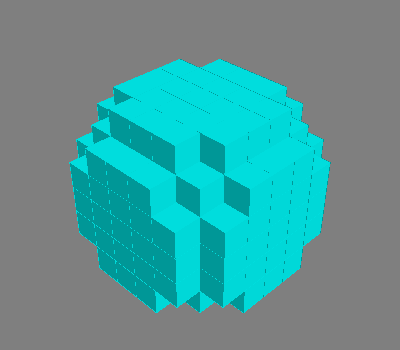

In [4]:
test_sphere = dataset[12].detach().numpy()
visualize3D(test_sphere, color=(0,1,1), thresh= 0.1)
visualize3D(test_sphere, color=(0,1,0), thresh= 0.1)

In [ ]:
class DiscriminatorNet(torch.nn.Module):
    """
    A three hidden-layer discriminative neural network
    """
    def __init__(self):
        super(DiscriminatorNet, self).__init__()
        n_out = 1
        
        self.hidden0 = nn.Sequential( 
            # start with a 16x16x16 model (1 channel)
            nn.Conv3d(in_channels = 1, out_channels = 64, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # now 14x14x14
            nn.Conv3d(in_channels = 64, out_channels = 32, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 12x12x12
            nn.MaxPool3d(2, stride=2)
            # 6x6x6
        )
        self.hidden1 = nn.Sequential(
            # 6x6x6
            nn.Conv3d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 4x4x4
            nn.Conv3d(in_channels = 16, out_channels = 1, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            # 2x2x2
        )
        self.out = nn.Sequential(
            nn.Linear(8, n_out),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.hidden0(x)
        x = self.hidden1(x)
        # reshape 2x2x2 model to vector of length 8
        x = x.reshape(x.shape[0], 8)
        x = self.out(x)
        return x

discriminator = DiscriminatorNet()

In [ ]:
class GeneratorNet(torch.nn.Module):
    """
    A three hidden-layer generative neural network
    """
    def __init__(self):
        super(GeneratorNet, self).__init__()
        n_features = 100
        n_out = 784
        
        self.linear = nn.Linear(n_features, 343)
        # 7x7x7
        self.upsample = nn.Upsample(scale_factor=2, mode='nearest')
        # 14x14x14
        self.hidden0 = nn.Sequential(
            nn.Conv3d(in_channels = 1, out_channels = 32, kernel_size = 3, stride = 1, padding = 2),
            nn.LeakyReLU(0.2)
        )
        # 16x16x16
        self.hidden1 = nn.Sequential(
            nn.Conv3d(in_channels = 32, out_channels = 16, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2)
        )
        # 16x16x16
        self.hidden2 = nn.Sequential(
            nn.Conv3d(in_channels = 16, out_channels = 8, kernel_size = 3, stride = 1, padding = 1),
            nn.LeakyReLU(0.2)
        )
        # 16x16x16
        self.out = nn.Sequential(
            nn.Conv3d(in_channels = 8, out_channels = 1, kernel_size = 3, stride = 1, padding = 1),
            nn.Tanh()
        )

    def forward(self, x):
        # 1x100
        x = self.linear(x)
        # 1x343
        x = x.reshape(x.shape[0], 1, 7, 7, 7)
        # 1x7x7x7
        x = self.upsample(x)
        # 1x14x14x14
        x = self.hidden0(x)
        # 32x16x16x16
        x = self.hidden1(x)
        # 16x16x16x16
        x = self.hidden2(x)
        # 8x16x16x16
        x = self.out(x)
        # 1x16x16x16
        return x

generator = GeneratorNet()

In [ ]:
def noise(size):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn(size, 100))
    return n

In [ ]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002)

In [ ]:
loss = nn.BCELoss()

In [ ]:
def ones_target(size):
    '''
    Tensor containing ones, with shape = size
    '''
    data = Variable(torch.ones(size, 1))
    return data

def zeros_target(size):
    '''
    Tensor containing zeros, with shape = size
    '''
    data = Variable(torch.zeros(size, 1))
    return data

In [ ]:
def train_discriminator(optimizer, real_data, fake_data):
    N = real_data.size(0)
    # Reset gradients
    optimizer.zero_grad()
    
    # 1.1 Train on Real Data
    prediction_real = discriminator(real_data)
    # Calculate error and backpropagate
    error_real = loss(prediction_real, ones_target(N) ) # try to modify prediction back to vectors
    error_real.backward()

    # 1.2 Train on Fake Data
    prediction_fake = discriminator(fake_data)
    # Calculate error and backpropagate
    error_fake = loss(prediction_fake, zeros_target(N))
    error_fake.backward()
    
    # 1.3 Update weights with gradients
    optimizer.step()
    
    # Return error and predictions for real and fake inputs
    return error_real + error_fake, prediction_real, prediction_fake

In [ ]:
def train_generator(optimizer, fake_data):
    N = fake_data.size(0)

    # Reset gradients
    optimizer.zero_grad()

    # Sample noise and generate fake data
    prediction = discriminator(fake_data)

    # Calculate error and backpropagate
    error = loss(prediction, ones_target(N))
    error.backward()

    # Update weights with gradients
    optimizer.step()

    # Return error
    return error

In [ ]:
num_test_samples = 16
test_noise = noise(num_test_samples)

In [ ]:
# Create logger instance
logger = Logger(model_name='3DVGAN', data_name='3DMNIST')

# Total number of epochs to train
num_epochs = 200

for epoch in range(num_epochs):
    for n_batch, (real_batch) in enumerate(data_loader):
        # this will be 100 since batch_size is 100 as defined earlier
        N = real_batch.size(0)

        # 1. Train Discriminator
        # real_data = Variable(images_to_vectors(real_batch))
        real_data = Variable(real_batch) # don't switch this time

        # Generate fake data and detach 
        # (so gradients are not calculated for generator)
        fake_data = generator(noise(N)).detach()

        # Train D
        d_error, d_pred_real, d_pred_fake = \
              train_discriminator(d_optimizer, real_data, fake_data)

        # 2. Train Generator

        # Generate fake data
        fake_data = generator(noise(N)) 

        # Train G
        g_error = train_generator(g_optimizer, fake_data)

        # Log batch error
        logger.log(d_error, g_error, epoch, n_batch, num_batches)

        # Display Progress every few batches
        if (n_batch) % 30 == 0: 

            #logger.log_images(
            #    test_images, num_test_samples, 
            #    epoch, n_batch, num_batches
            #);
            
            # Display status Logs
            logger.display_status(
                epoch, num_epochs, n_batch, num_batches,
                d_error, g_error, d_pred_real, d_pred_fake
            )

/home/arafian-admin/env/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:122: UserWarning: nn.Upsampling is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.Upsampling is deprecated. Use nn.functional.interpolate instead.")


Epoch: [0/200], Batch Num: [0/60]
Discriminator Loss: 1.3947, Generator Loss: 0.7584
D(x): 0.4648, D(G(z)): 0.4665
Epoch: [1/200], Batch Num: [0/60]
Discriminator Loss: 1.7345, Generator Loss: 0.4253
D(x): 0.5746, D(G(z)): 0.6693
Epoch: [2/200], Batch Num: [0/60]
Discriminator Loss: 0.7778, Generator Loss: 4.5732
D(x): 0.5508, D(G(z)): 0.0810
